# Artificial IntelligenceApplied toSatellite-based RemoteSensing Data for EarthObservation
## Chapter 7 - Example 1: Noise Filter

The aim of this project is to implement a model able to filter noise from a sine wave.

Load the [NumPy](https://numpy.org/) library. NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

In [ ]:
import numpy as np

Load the [Matplotlib](https://matplotlib.org/) library. Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+. There is also a procedural "pylab" interface based on a state machine (like OpenGL), designed to closely resemble that of MATLAB, though its use is discouraged. SciPy makes use of Matplotlib.


In [ ]:
import matplotlib.pyplot as plt

Load some functions from [Tensorflow.Keras](https://www.tensorflow.org/api_docs/python/tf/keras) library. Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

## Create the dataset
For this simple project the dataset is created on-line. A common practice in Deep Learning is the use of generators. Basically a generator is composed of an infinite while loop and of the yield keyword. The generator is used to avoid memory problems, infact the datast is not loaded all in once, but batch by batch.

In [ ]:
def dataset_generator(batch_size, time_size): 
  x_train = np.zeros((batch_size, time_size))
  y_train = np.zeros((batch_size, time_size))
  t = np.linspace(-3*np.pi, 3*np.pi, time_size)

  while True:
      
    for i in range(batch_size):
      # Create random sine waves with
      m = np.random.randint(1, 4)
      d = np.random.randint(-90, 90)

      x_train[i,...] = np.sin(m*t + d)/2.0
      y_train[i,...] = np.sin(m*t + d)/2.0
      # Add noise to x_train
      for dt in range(time_size):
        error = np.random.normal(0, 1, size = 1)
        x_train[i, dt] = x_train[i, dt] + 0.3*error/2.0

    yield x_train, y_train

To call the generator you should use the following commands

In [ ]:
# Create an instance of the dataset_generator
generator = dataset_generator(32, 300)

# Get the iterator from the generator 
iterator = iter(generator)

# Get a batch of data
x_train, y_train = next(iterator)

Let have a look of x_train and y_train

In [ ]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)

x_train shape:  (32, 300) y_train shape:  (32, 300)


As you can see both the x_train and y_train have the same shape (batch_size, lenght). Let plot an example.

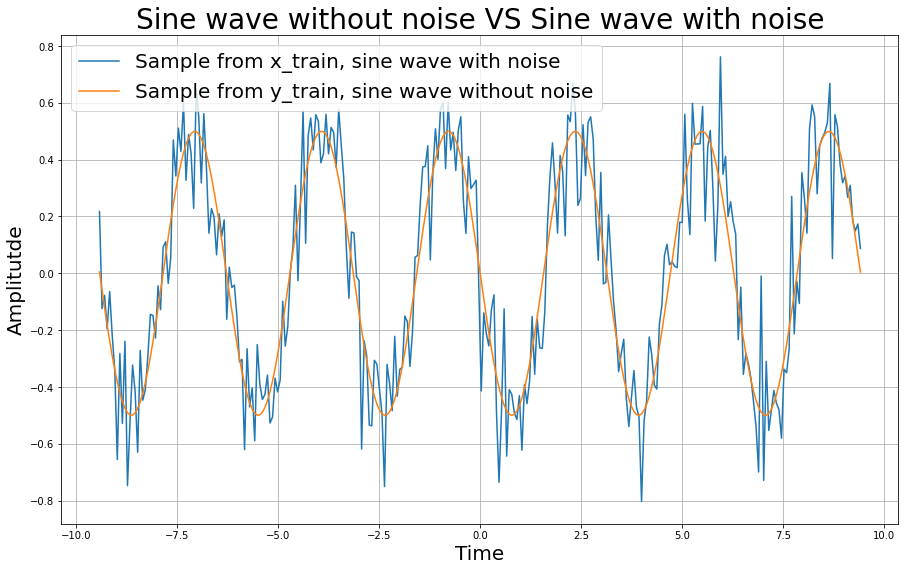

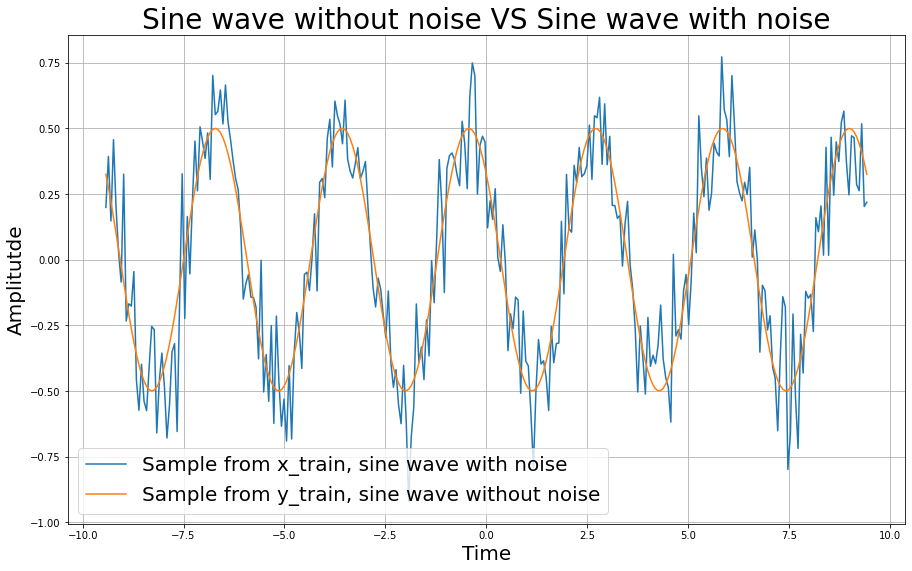

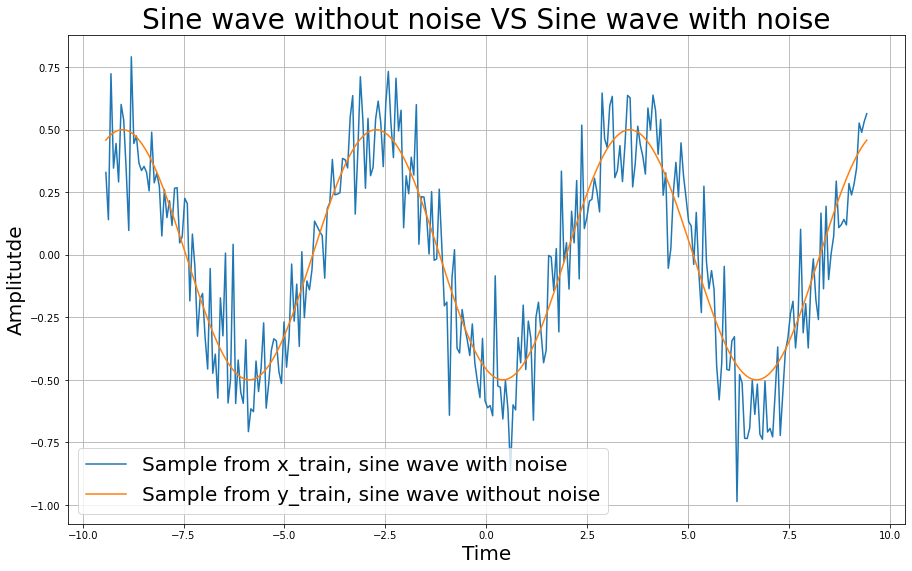

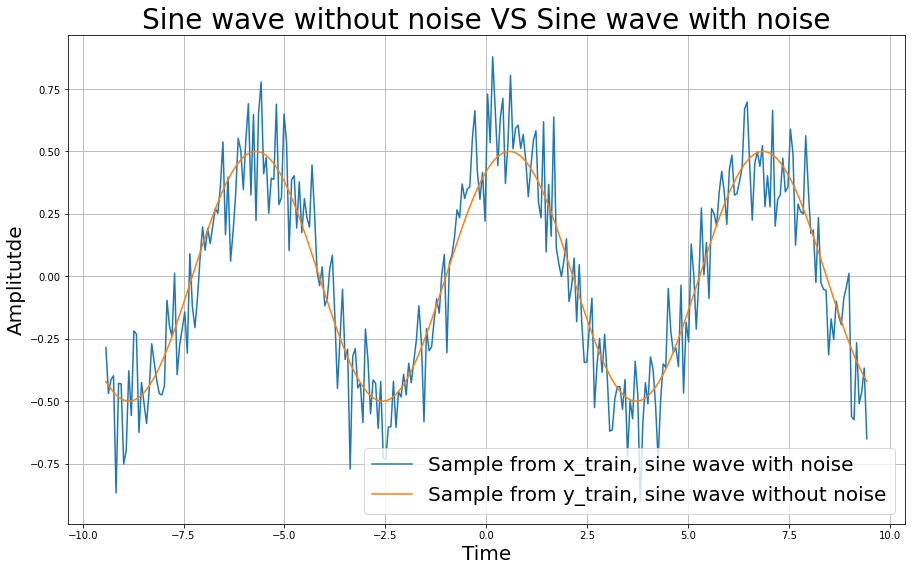

In [ ]:
for _ in range(4):

  sample =  np.random.randint(0, x_train.shape[0])
  t = np.linspace(-3*np.pi, 3*np.pi, x_train.shape[1])

  fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,9))

  ax.plot(t, x_train[sample, ...], label = 'Sample from x_train, sine wave with noise')
  ax.plot(t, y_train[sample, ...], label = 'Sample from y_train, sine wave without noise')

  ax.set_xlabel('Time', fontsize = 20)
  ax.set_ylabel('Amplitutde', fontsize = 20)
  ax.set_title('Sine wave without noise VS Sine wave with noise', fontsize = 28)

  ax.legend(fontsize = 20)
  ax.grid()


  plt.show()

# Build a model

The model is composed of different Dense layer, with a size defined by the variable time_size and the Tanh as activation function

In [ ]:
time_size =  x_train.shape[1]

model = Sequential()
model.add(Dense(time_size, input_dim=time_size, activation='tanh'))
model.add(Dense(time_size/2, activation='tanh'))
model.add(Dense(time_size/4, activation='tanh'))
model.add(Dense(time_size, activation='tanh'))

Compile the model using the MSE as loss function and Adam as optimizer

In [ ]:
model.compile(loss='mae', optimizer='adam')

Show the model structure

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_9 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_10 (Dense)             (None, 75)                11325     
_________________________________________________________________
dense_11 (Dense)             (None, 300)               22800     
Total params: 169,575
Trainable params: 169,575
Non-trainable params: 0
_________________________________________________________________
None


# Model training
The model will be trained with the function fit_generator, for 20 epcohs. This function uses generators, both for training and validations set. Since the generator are producing an infiniry of samples, using steps_per_epoch and validation_step, the user can define an arbitrary size for the dataset.

In [ ]:
history = model.fit_generator(
  dataset_generator(32, time_size),
  steps_per_epoch=10000//32,
  validation_data=dataset_generator(16, time_size),
  validation_steps=10000//16,
  epochs=20
)

Epoch 1/20
312/312 [==============================] - 74s 238ms/step - loss: 0.0472 - val_loss: 0.0223
Epoch 2/20
312/312 [==============================] - 74s 237ms/step - loss: 0.0188 - val_loss: 0.0175
Epoch 3/20
312/312 [==============================] - 74s 236ms/step - loss: 0.0161 - val_loss: 0.0147
Epoch 4/20
312/312 [==============================] - 76s 242ms/step - loss: 0.0148 - val_loss: 0.0139
Epoch 5/20
312/312 [==============================] - 77s 246ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 6/20
312/312 [==============================] - 77s 247ms/step - loss: 0.0131 - val_loss: 0.0118
Epoch 7/20
312/312 [==============================] - 76s 244ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 8/20
312/312 [==============================] - 76s 243ms/step - loss: 0.0132 - val_loss: 0.0121
Epoch 9/20
312/312 [==============================] - 77s 245ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 10/20
312/312 [==============================] - 77s 245ms/step - l

Plot the training score

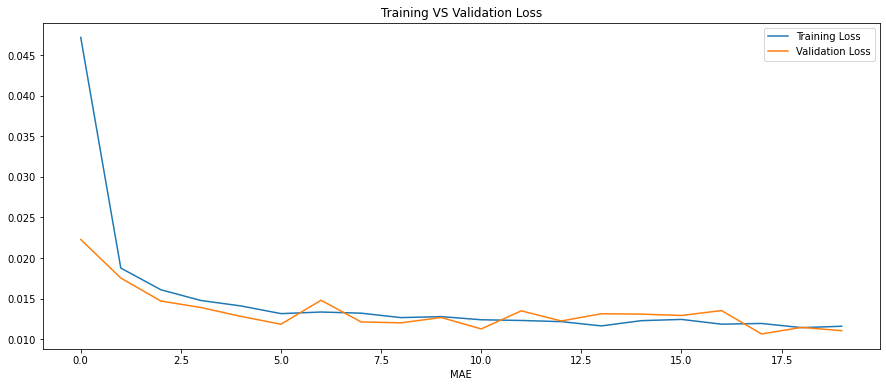

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15, 6))
ax.plot(history.history['loss'], label = 'Training Loss')
ax.plot(history.history['val_loss'], label = 'Validation Loss')

ax.set_title('Training VS Validation Loss')
ax.set_xlabel('Epochs')
ax.set_xlabel('MAE')

ax.legend()
plt.show()

# Test the trained model

Load new samples through the generator and predict the output

In [ ]:
x_train, y_train = next(iter(dataset_generator(10, time_size)))
pred = model.predict(x_train)

Plot the results

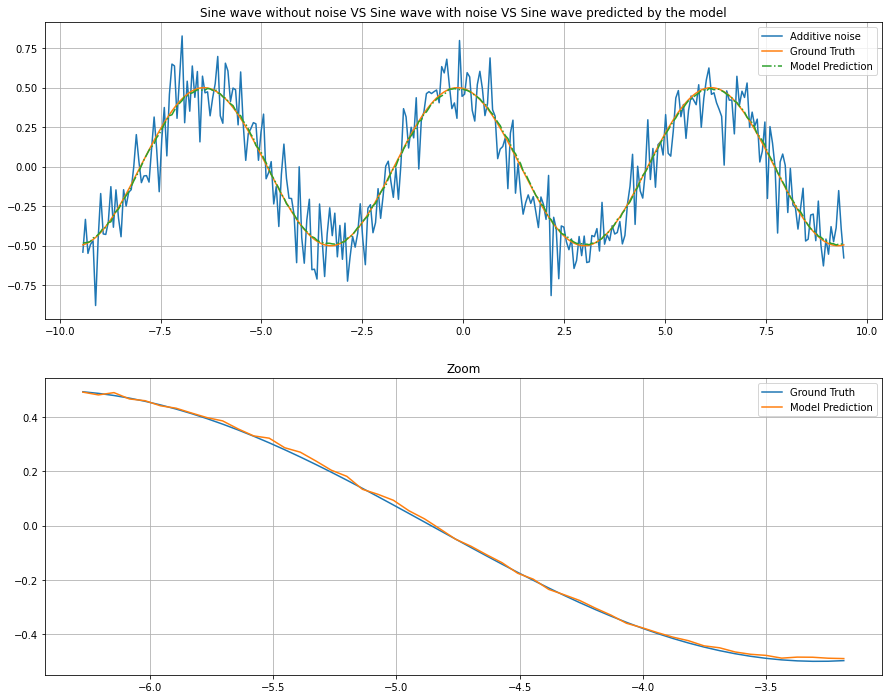

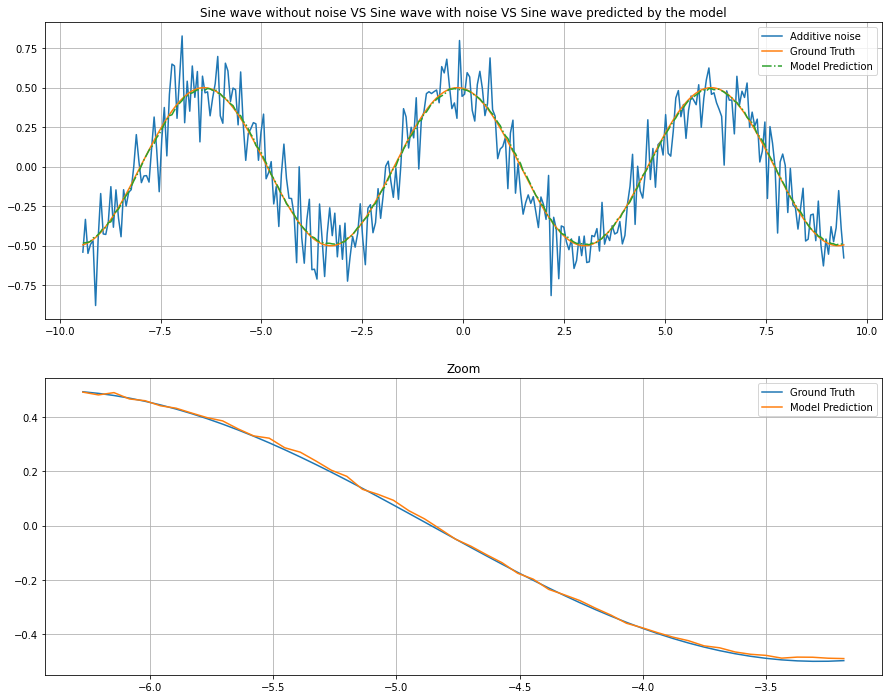

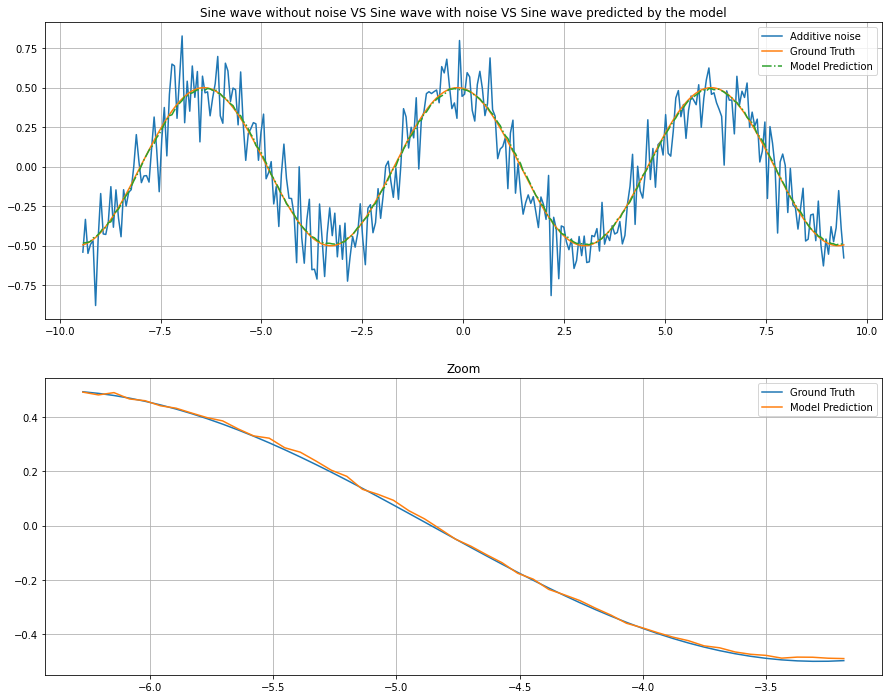

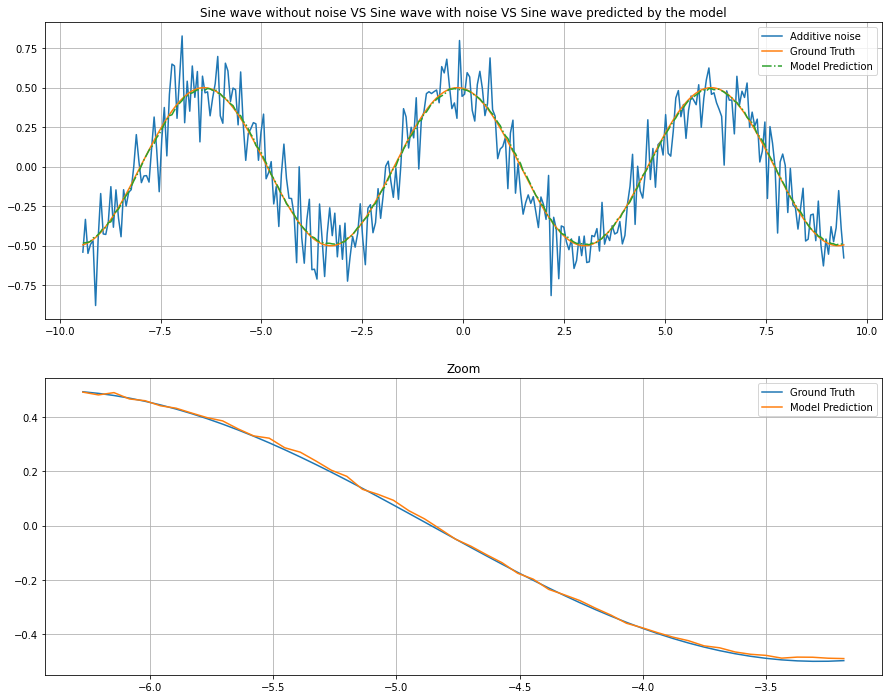

In [ ]:
for i in range(4):
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (15, 12))

  t = np.linspace(-3*np.pi, 3*np.pi, time_size)
  axes[0].plot(t, x_train[0,...], label = 'Additive noise')
  axes[0].plot(t, y_train[0,...], label = 'Ground Truth')
  axes[0].plot(t, pred[0,...], '-.',label = 'Model Prediction')

  axes[0].set_title('Sine wave without noise VS Sine wave with noise VS Sine wave predicted by the model')

  axes[0].legend()
  axes[0].grid()

  axes[1].plot(t[50:100], y_train[0,50:100], label = 'Ground Truth')
  axes[1].plot(t[50:100], pred[0,50:100], label = 'Model Prediction')
  axes[1].set_title('Zoom')

  axes[1].legend()
  axes[1].grid()

  plt.show()